In [198]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [199]:
# Indicators which are expected to indicate urbanization if their values are high
URBANIZATION_INDICATORS = [
    'Air transport, freight (million ton-km)',
    'Air transport, passengers carried',
    'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)',
    'CO2 emissions (metric tons per capita)',
    'Commercial bank branches (per 100,000 adults)',
    'Employment in industry (% of total employment) (modeled ILO estimate)',
    'Employment in services (% of total employment) (modeled ILO estimate)',
    'Industry (including construction), value added per worker (constant 2010 US$)',
    'Manufacturing, value added (% of GDP)',
    'Medium and high-tech industry (% manufacturing value added)',
    'Railways, goods transported (million ton-km)',
    'Railways, passengers carried (million passenger-km)',
    'Urban population (% of total)',
    
    # Other indicators that could be used (internet access tends to be better in densely populated areas, more universities in
    # cities)
    'Individuals using the Internet (% of population)',
    "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
    "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)",
]

# Indiccators which are expected to indicate urbanization if their values are low
ANTI_URBANIZATION_INDICATORS = [
    'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
    'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)',
    'Employment in agriculture (% of total employment) (modeled ILO estimate)',
    'Forest area (% of land area)',
]

In [200]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()


,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [201]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

/tmp/ipykernel_5950/3317798125.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_impute = df_thresh.fillna(df_thresh.mean())


,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [202]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [203]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [204]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [205]:
X, Y = split_X_Y(train)

In [206]:
X

,"Industry (including construction), value added per worker (constant 2010 US$)","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)",Urban population (% of total),Individuals using the Internet (% of population),"Manufacturing, value added (% of GDP)",Employment in services (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),"Commercial bank branches (per 100,000 adults)","Air transport, passengers carried",Employment in agriculture (% of total employment) (modeled ILO estimate)
117,26120.900466,9104.030650,78.566000,54.215766,13.897199,71.918999,18.365,12.570840,1.446300e+04,9.715000
95,46408.864921,11633.195613,87.422000,82.327487,10.820990,67.509003,23.011,16.031553,1.636244e+07,9.480000
126,11963.106721,5070.377767,42.732000,41.248067,16.841326,48.924000,25.503,13.890841,1.184496e+07,25.573999
148,23036.702831,20761.228907,55.169177,42.805461,12.666669,47.520000,18.618,13.890841,1.814317e+07,33.862000
243,23036.702831,20761.228907,55.169177,42.805461,12.666669,19.796000,8.299,13.890841,1.814317e+07,71.905998
...,...,...,...,...,...,...,...,...,...,...
363,28750.424936,9820.117264,65.341000,54.000000,12.040173,71.095001,23.334,10.163461,1.974493e+07,5.572000
420,4665.656876,553.076465,23.196000,23.706531,8.593108,21.648001,7.282,2.578919,5.493700e+04,71.070000
146,5125.335603,2767.155676,54.749000,34.666001,11.122444,46.699001,18.601,7.128309,3.595160e+05,34.700001
157,9242.322804,789.315439,52.427000,12.197700,6.586690,39.820000,10.414,2.663096,1.814317e+07,49.765999


In [207]:
Y

,Generosity,Perceptions of corruption,Social support,Freedom,Dystopia residual,GDP per capita,Life expectancy
117,0.216840,0.142340,1.172020,0.576720,1.213050,0.895370,0.668250
95,0.315950,0.114510,0.905870,0.377890,2.955050,1.216700,0.818830
126,0.127060,0.103930,0.498130,0.188470,1.968950,0.953950,0.521160
148,0.212000,0.029000,0.896000,0.499000,2.092000,0.592000,0.337000
243,0.210000,0.080000,0.541000,0.531000,1.733000,0.186000,0.306000
...,...,...,...,...,...,...,...
363,0.136560,0.084150,0.960530,0.424830,1.642270,1.024160,0.186110
420,0.325766,0.057070,1.129828,0.443186,1.526363,0.381431,0.217633
146,0.212030,0.032600,0.493530,0.409730,2.200200,0.631070,0.296810
157,0.461870,0.171750,0.743020,0.244250,2.241730,0.266730,0.388470


In [208]:
scaler = norm_transform_gen(X.to_numpy())
X_scaled = scaler.transform(X.to_numpy())

In [209]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__() 
        self.linear = nn.Linear(in_features=in_features, out_features=out_features)
    
    def forward(self, x):
        return self.linear(x);

In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y.to_numpy()).to(device)

In [211]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [212]:
X_test, Y_test = split_X_Y(test)
X_test = scaler.transform(X_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test.to_numpy()).to(device)
mse_loss = nn.MSELoss()

In [213]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.5935736298561096
loss: 0.2156122773885727
loss: 0.10625693202018738
loss: 0.08259841054677963
loss: 0.07657185196876526
loss: 0.07421014457941055
loss: 0.07292284816503525
loss: 0.07210762053728104
loss: 0.07155800610780716
loss: 0.07117447257041931


In [214]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'loss')

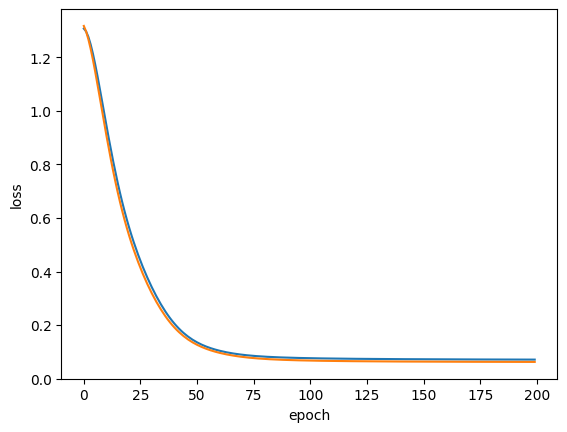

In [217]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [216]:
torch.save(model.state_dict(), 'weights/fenn.pt')